In [27]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# set defaults
plt.style.use('seaborn-white')   # seaborn custom plot style
plt.rc('figure', dpi=100, figsize=(7, 5))   # set default size/resolution
plt.rc('font', size=12)   # font size

# Lecture 17

### Testing Hypotheses

## Choosing One of Two Viewpoints 
* Based on data, one can try to determine:

    - “Chocolate has no effect on cardiac disease.”
    - “Yes, Chocolate does have an effect on cardiac disease.”

* Based on data, one can try to determine:

    - “This jury panel was selected at random from eligible jurors.”
    - “No, it has too many people with college degrees.”



### Discussion Question

Suppose, given a coin, you want to understand whether a coin is not fair. In each of (a) and (b):
* Design an experiment (involving flipping the coin) to decide between the two viewpoints.
* Choose a statistic that will help you decide between the two viewpoints.

(a) “This coin is fair.” vs. “No, it’s not.”

(b) “This coin is fair.” vs. “No, it’s biased towards heads.”


### Answer: "Is this coin fair?"

* Starting point: number of heads in 400 tosses.
* Number near `0.5 * 400` suggests 'fair'.

### Answers to the negative(s)

* Large/small values of the number of heads suggest "not fair"
    - The **distance** between number of heads and 200.
    - Statistic: | number of heads - 200 |
    - Large values of the statistic suggest "not fair"
    
* Large values of the number of heads suggest "biased toward heads".
    - Statistic: number of heads

## Let's simulate our experiment

Assess the truth of "this coin is biased toward heads"

* Pick a possibly biased coin.
* Flip the coin in question 400 times.
* Flip a *fair* coin 400 times (and repeat)
* Ask: does our coin look like the fair one?

### Pick a (possibly) biased coin
* Don't look!
* Flip this coin 400 times

In [28]:
#:
np.random.seed(42)

# pick a (possibly) biased coin
prob = np.random.choice([0.4, 0.5, 0.6])

# flip this coin 400 times; flips = [Num Heads, Num Tails]
flips = np.random.choice([0,1], p=[prob, 1-prob], size=400)
num_tails = np.sum(flips)
flip_cnts = [400 - num_tails, num_tails]

In [29]:
flip_cnts

[247, 153]

### Compute the statistics
* Is the coin biased toward heads?
* Try it on our observation `flips_cnts`.

In [30]:
def num_heads(arr):
    return arr[0]

In [32]:
# Are these number what you would see from a fair coin?
print(num_heads(flip_cnts))

247


### What do these statistics look like for a fair coin?
* Define the probability model for a fair coin
* Define our test statistic (Done)
* Run the simulation: flip coins, calculate statistic, add to results, repeat
* Write results of simulation into an array `results`

In [33]:
def prob_model(nflips=400):
    fair_coin = [0.5, 0.5]
    
    flips = np.random.choice([0,1], p=fair_coin, size=nflips)
    num_tails = np.sum(flips)
    flip_cnts = [nflips - num_tails, num_tails]
    return flip_cnts

In [34]:
repetitions = 10000
results = []

for _ in np.arange(repetitions):
    flips = prob_model()
    result = num_heads(flips)
    results.append(result)

results = np.array(results)

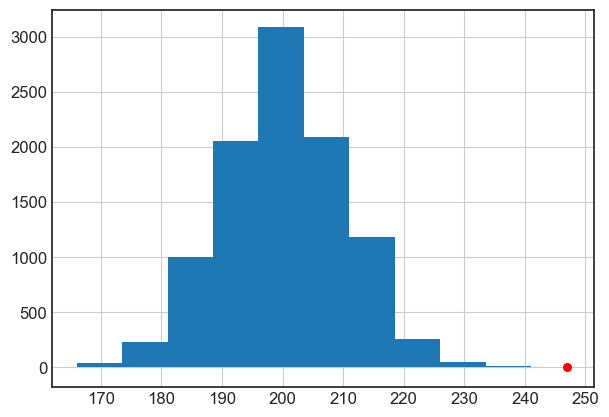

In [35]:
pd.Series(results).hist()
plt.scatter(num_heads(flip_cnts), 0, color='red', s=30);

In [37]:
num_heads(flip_cnts)

247

### Was the coin biased?
* The difference between observed and simulated seems significant!
* What if the coin were biased just a little?

In [38]:
# probability
prob

0.6

## Hypothesis testing

Faced with a question about the data raised by an observation...
1. Carefully pose the question as a testable "yes or no" hypothesis.
2. Decide on a statistic that helps differentiate between instances that would affirm or reject the hypothesis.
3. Create a probability model for the data generating process that reflects the "known behavior" of the process.
4. Simulate the data generating process using this probability model (the 'Null Hypothesis').
5. Assess if the observation is consistent with the simulations.

What is each step in the biased coin example?

### Jury Selection in Alameda County

<img src="imgs/image_0.png" width="75%">

See example from [DSC 10](https://www.inferentialthinking.com/chapters/11/2/Multiple_Categories.html).

## Jury Panels

<img src="imgs/image_1.png">

Section 197 of California's Code of Civil Procedure says, 
> "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

### ACLU study:
* ACLU studied the ethnic compisition of jury panels in 11 felony trials in Alameda county between 2009 and 2010.
* Total number of people reporting for jury duty: 1453
* Compared to demographics of the county

In [39]:
jury = pd.DataFrame([
    ['Asian', 0.15, 0.26],
    ['Black', 0.18, 0.08],
    ['Latino', 0.12, 0.08],
    ['White', 0.54, 0.54],
    ['Other', 0.01, 0.04]
], columns='Ethnicity,Eligible,Panels'.split(',')).set_index('Ethnicity')

jury

,Eligible,Panels
Ethnicity,,
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


### Are the differences in representation meaningful?
* Model: The people on the jury panels were selected at random from the eligible population
    - Alternative viewpoint: no, they weren't.
* Observed: Empirical distribution of panels
* Statistic: similarity to the "distribution of eligible jurors"
    - Distance between distributions? TVD

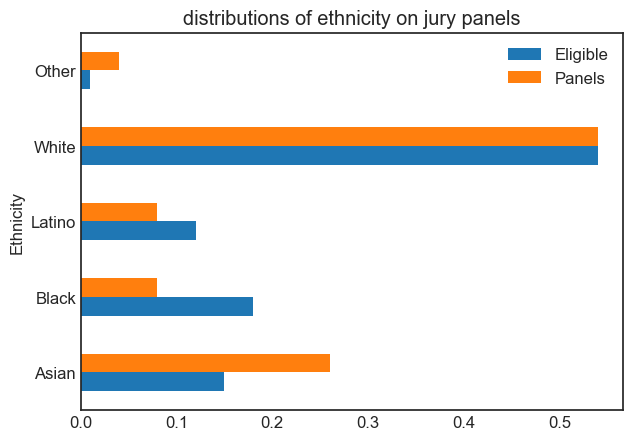

In [42]:
title='distributions of ethnicity on jury panels'
jury.plot(kind='barh', title=title);


In [43]:
def total_variation_distance(dist1, dist2):
    '''Given two empirical distributions, 
    both sorted with same categories, calculates the TVD'''
    return np.sum(np.abs(dist1 - dist2)) / 2

In [44]:
# Is this large? small? 
# sample from the model to understand the variation!
observed = total_variation_distance(jury['Eligible'], jury['Panels'])
observed

0.14

### Simulate drawing jury panels
* Model: Draw a random panel from "eligible" distribution
* Statistic: TVD between random panel and eligible
* Repeat and compare to observed statistic!

In [45]:
# sample 1453 jurors from eligible: sample a jury pool

draw = np.random.choice(jury.index, p=jury['Eligible'], size=1453)
rand_panel_props = pd.Series(draw).value_counts(normalize=True).rename('random panel')
rand_panel_props.to_frame()

,random panel
White,0.550585
Black,0.168617
Asian,0.142464
Latino,0.132140
Other,0.006194


In [48]:
with_samp = jury.copy()
with_samp['random panel'] = rand_panel_props
with_samp

,Eligible,Panels,random panel
Ethnicity,,,
Asian,0.15,0.26,0.142464
Black,0.18,0.08,0.168617
Latino,0.12,0.08,0.132140
White,0.54,0.54,0.550585
Other,0.01,0.04,0.006194


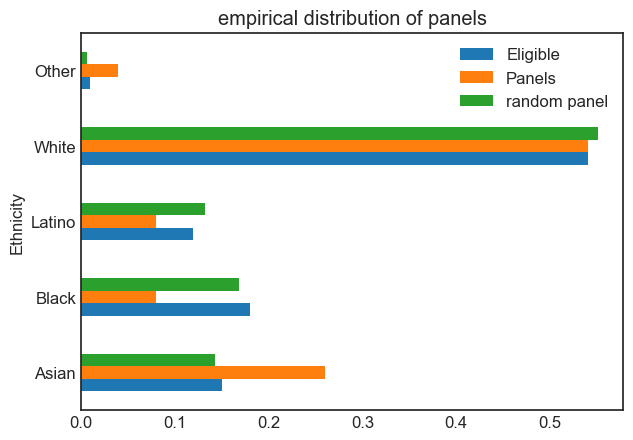

In [50]:
with_samp.plot(kind='barh', title='empirical distribution of panels');

In [51]:
total_variation_distance(with_samp['random panel'], with_samp['Eligible'])

0.022725395732966242

### Put together the simulation

In [52]:
tvds = []

for i in np.arange(1000):
    draw = np.random.choice(jury.index, p=jury['Eligible'], size=1453)
    rand_panel_props = pd.Series(draw).value_counts(normalize=True).rename('random panel')
    new_tvd = total_variation_distance(rand_panel_props, jury['Eligible'])
    tvds.append(new_tvd)

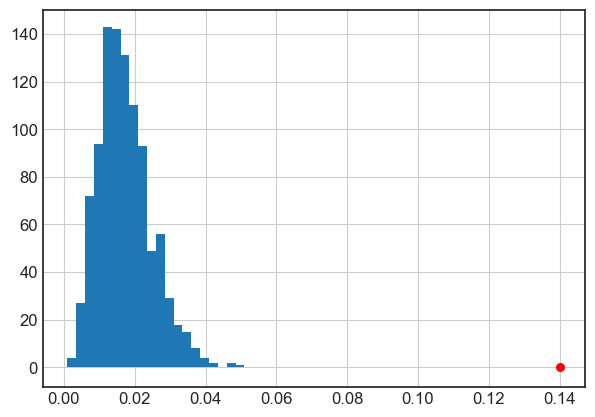

In [53]:
observed_tvd = total_variation_distance(jury['Panels'], jury['Eligible'])

pd.Series(tvds).hist(bins = 20)
plt.scatter(observed_tvd, 0, color='red', s=30);

### How to speed up the simulation?

* Get rid of the loop!
* Use `np.random.multinomial`

In [54]:
rndm = np.random.multinomial(1453, jury['Eligible'], size=10000)
rndm = rndm / 1453 # normalize the counts

In [55]:
# need to vectorizize the TVD to apply it row-wise
tvds = np.sum(np.abs(rndm - jury['Eligible'].values), axis=1) / 2  

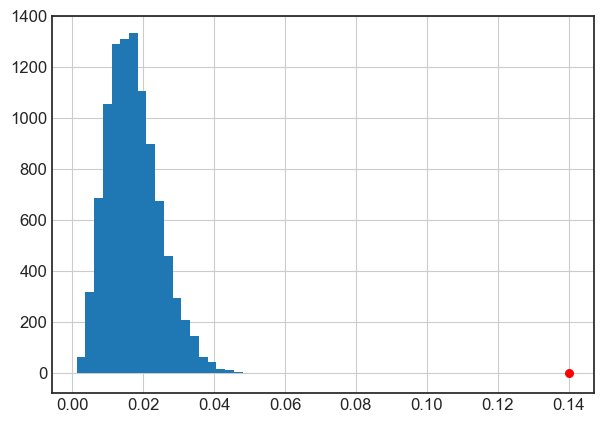

In [56]:
observed_tvd = total_variation_distance(jury['Panels'], jury['Eligible'])

pd.Series(tvds).hist(bins = 20)
plt.scatter(observed_tvd, 0, color='red', s=30);

### Are the jury panels representative?
* Likely not! The random samples are not like the observed panels.
* This doesn't say *why* the distributions are different!
    - Juries drawn from voter rolls and DMV.
    - The county rarely follows up on failures to report.
    - [Building the jury table is complicated](https://www.inferentialthinking.com/chapters/11/2/Multiple_Categories.html)!

### Summary of the method

To assess whether an "observed sample" was drawn randomly from a known categorical distribution:
* Use TVD as the statistic because it measures the distance between categorical distributions
* Sample at random from the population and compute the TVD of the random sample and known distribution; repeat numerous times
* Compare:
    - Empirical distribution of simulated TVDs
    - Actual TVD from the sample in the study


# Decisions and Uncertainty

## Incomplete Information

<div class="image-txt-container">
    
* Want to Choose between two views of the world, based on data in a sample.
* It's not always clear whether the data are consistent with one view or the other.
* Random samples can turn out quite extreme. It is unlikely, but possible.
* *"Is this jury panel representative of the county?"*

<img src="imgs/jury_diversity.jpg" width="50%"/>

</div>

## Testing Hypotheses

<div class="image-txt-container">

* A test chooses between two views of how data were generated
* The views are called **hypotheses**
* The test picks the hypothesis that is better supported by the observed data
* *"the juries panels are / are not representative of the county."*

<img src="imgs/jury_diversity.jpg" width="50%"/>

</div>

## Null and Alternative

<div class="image-txt-container">

* The method only works if we can simulate data under one of the hypotheses.
* **Null hypothesis**
    - A well defined probability model about how the data were generated
    - We can simulate data under the assumptions of this model – “under the null hypothesis”
* **Alternative hypothesis**
    - A different view about the origin of the data

<img src="imgs/image_2.png" width="50%"/>

</div>

## Test Statistic

<div class="image-txt-container">
    
* The statistic that we choose to simulate, to decide between the two hypotheses
* What values of the statistic will make us lean towards the null hypothesis?
* What values will make us lean towards the alternative?

<img src="imgs/jury_tvd.png" width="100%">

</div>


## Prediction Under the Null Hypothesis

<div class="image-txt-container">

* Simulate the test statistic under the null hypothesis; draw the histogram of the simulated values
* This displays the **empirical distribution of the statistic under the null hypothesis**
* It shows all the likely values of the statistic
* The probabilities are approximate, because we can't generate all the possible random samples.


<img src="imgs/null_distribution.png" width="75%">

</div>


## Conclusion of the Test

<div class="image-txt-container">

* Resolving the choice between null and alternative hypotheses
* Compare the **observed test statistic** and the empirical distribution under the null hypothesis.
* If the observed value is **not consistent** with the distribution, then the test favors the alternative – “rejects the null hypothesis”

<img src="imgs/conclusion.png" width="100%">

</div>


## Examples of Null hypothesis

Often (but not always) the null hypothesis states there is no association or difference between variables or subpopulations. Like so, some typical null hypotheses are:

* The average income for men is similar to that for women 
* Nationality is (perfectly) unrelated to music preference
* The average population income was equal over 2012 through 2016


## Example of Alternative hypothesis

Hypothesis that sample observations are influenced by some non-random cause (unlike Null Hypothesis).


About 10% of the human population is left-handed. Suppose Aaron speculates that students in his class are more likely to be left-handed than people found in the general population.  


**Null Hypothesis:** Students in Aaron's class are no more likely to be left-handed than people in the general population.

**Alternative Hypothesis:** Students in Aaron's class are more likely to be left-handed than people in the general population.


### Check point:

Which of the following is the best example of a null hypothesis?

|option|answer|
|---|---|
|A| There will be no relationship between the amount of cookies you eat and your blood sugar level.|
|B| As the amount of cookies you eat increases, your blood sugar level will increase.|
|C| As the amount of cookies you eat increases, your blood sugar level will decrease.|
|D| As the amount of cookies you eat decreases, your blood sugar level will remain constant.|

## Performing a Hypothesis Test

### The Problem

* Large Statistics class divided into 12 discussion sections
* TAs lead the sections

* After the midterm, students in Section 3 notice that the average score in their section is lower than in others.




### The TA's Defense

TA’s position (Null Hypothesis):
* If we had picked my section at random from the whole class, we could observe an average score like this one.

Alternative:
* No, the average score is too low. Randomness is not the only reason for the low scores.


In [57]:
scores = pd.read_csv('data/scores_by_section.csv')
scores.head()

,Section,Midterm
0,1,22
1,2,12
2,2,23
3,2,14
4,1,20


### What are the observed characteristics of section 3?
* Size of section? (`section_size`)
* Average of section? (`observed_avg`)

In [62]:
# average midterm score per section
scores.groupby('Section').agg(['size','mean'])

Midterm           
           size       mean
Section                   
1            32  15.593750
2            32  15.125000
3            27  13.666667
4            30  14.766667
5            33  17.454545
6            32  15.031250
7            24  16.625000
8            29  16.310345
9            30  14.566667
10           34  15.235294
11           26  15.807692
12           30  15.733333

In [64]:
section_size = scores.loc[scores['Section'] == 3].shape[0]
section_size

27

In [65]:
observed_avg = scores.loc[scores['Section'] == 3, 'Midterm'].mean()
observed_avg

13.666666666666666

### Simulating the null hypothesis
* Probability Model: Sample uniformly (w/o replacement) 27 students from the class.
* Statistic: Calculate the average midterm score of each "random" section.

In [72]:
averages = []

for i in np.arange(50000):
    random_sample = scores.sample(int(section_size), replace=False)
    new_average = np.mean(random_sample['Midterm'])
    averages.append(new_average)
    
averages = np.array(averages)    

## The Verdict?

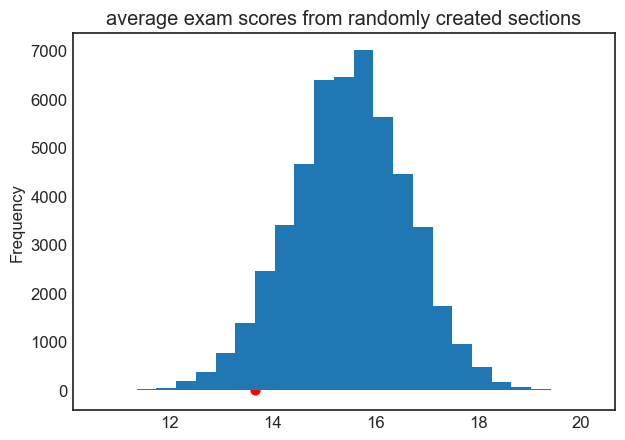

In [73]:
pd.Series(averages, name='Average').plot(
    kind='hist', 
    bins=25,
    title='average exam scores from randomly created sections'
)
plt.scatter(observed_avg, 0, color='red', s=40);

* Not as obvious as previous examples!
* Need a concept to capture the uncertainty of the conclusion.

### Question
* What is the probability that under the Null Hypothesis, a result *at least* as extreme as our observation holds?
* This quantity is called a **p-value**

In [74]:
np.count_nonzero(averages <= observed_avg) / 50000

0.05908

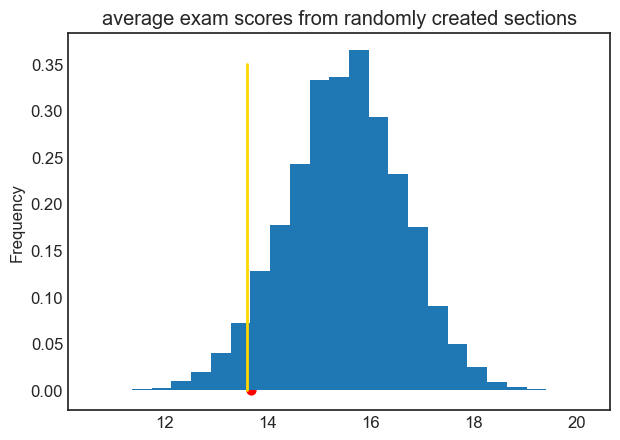

In [75]:
pd.Series(averages, name='Average').plot(
    kind='hist', 
    bins=25,
    title='average exam scores from randomly created sections',
    density=True
)
plt.scatter(observed_avg, 0, color='red', s=40);

plt.plot([13.6, 13.6], [0, 0.35], color='gold', lw=2);

# Statistical Significance

## Conventions About Inconsistency

* **“Inconsistent”**: The test statistic is in the tail of the empirical distribution under the null hypothesis

* **“In the tail,” first convention**:
    - The area in the tail is less than 5%
    - The result is “statistically significant”

* **“In the tail,” second convention**:
    - The area in the tail is less than 1%
    - The result is “highly statistically significant”


## Definition of the P-value

Formal name: **observed significance level**

The P-value is the chance, under the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative.

## An Error Probability

The cutoff for the P-value is an error probability.

* If:
    - your cutoff is 5%
    - and the null hypothesis happens to be true

* then there is about a 5% chance that your test will reject the null hypothesis.
